In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import time

In [ ]:

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration parameters
IMAGE_SIZE = (224, 224)  # Standard input size for many pre-trained models
BATCH_SIZE = 32
EPOCHS = 50
# NUM_CLASSES will be determined from the dataset
LEARNING_RATE = 0.0001

In [ ]:
def train_model(model, train_generator, validation_generator, data_directory):
    # Calculate class weights from train folder
    total_samples = sum([
        len(os.listdir(os.path.join(data_directory, "train", class_name)))
        for class_name in train_generator.class_indices.keys()
    ])
    
    class_weights = {}
    for class_name, class_index in train_generator.class_indices.items():
        samples = len(os.listdir(os.path.join(data_directory, "Train", class_name)))
        weight = (1 / samples) * (total_samples / len(train_generator.class_indices))
        class_weights[class_index] = weight

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_disease_detection_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )

    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[early_stopping, model_checkpoint],
        class_weight=class_weights
    )
    return history, model


In [ ]:
def create_model(num_classes):
    base_model = applications.MobileNetV2(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),  # Add batch normalization
        layers.Dense(512, activation='relu'),  # Larger intermediate layer
        layers.Dropout(0.5),  # Increase dropout
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),  # Add another dropout layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Use a lower learning rate
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.00001),  # Reduced learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
def load_and_preprocess_data(data_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.4,
        height_shift_range=0.4,
        shear_range=0.4,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.6,1.4],
        fill_mode='nearest'
    )
    
    valid_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, "Train"),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    
    validation_generator = valid_datagen.flow_from_directory(
        os.path.join(data_dir, "Val"),
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    
    return train_generator, validation_generator


In [ ]:
def main():
    data_directory = r"C:\Users\harsh\OneDrive\Desktop\Agrolens\tomato_ds"
    
    print("Loading and preprocessing data...")
    train_gen, val_gen = load_and_preprocess_data(data_directory)
    
    print("\nTraining data distribution:")
    for class_name, class_index in train_gen.class_indices.items():
        count = len(os.listdir(os.path.join(data_directory, "Train", class_name)))
        print(f"{class_name}: {count} images")
    
    num_classes = len(train_gen.class_indices)
    print(f"\nNumber of classes: {num_classes}")
    
    model_file = 'best_disease_detection_model.h5'
    if os.path.exists(model_file):
        print(f"\nLoading existing model from {model_file}")
        model = tf.keras.models.load_model(model_file)
    else:
        print("\nCreating and training new model...")
        model = create_model(num_classes)
        history, model = train_model(model, train_gen, val_gen, data_directory)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    


In [ ]:
if __name__ == "__main__":
    main()

Loading and preprocessing data...
Found 3736 images belonging to 2 classes.
Found 276 images belonging to 2 classes.

Training data distribution:
Ripe: 2072 images
Unripe: 1665 images

Number of classes: 2

Loading existing model from best_disease_detection_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


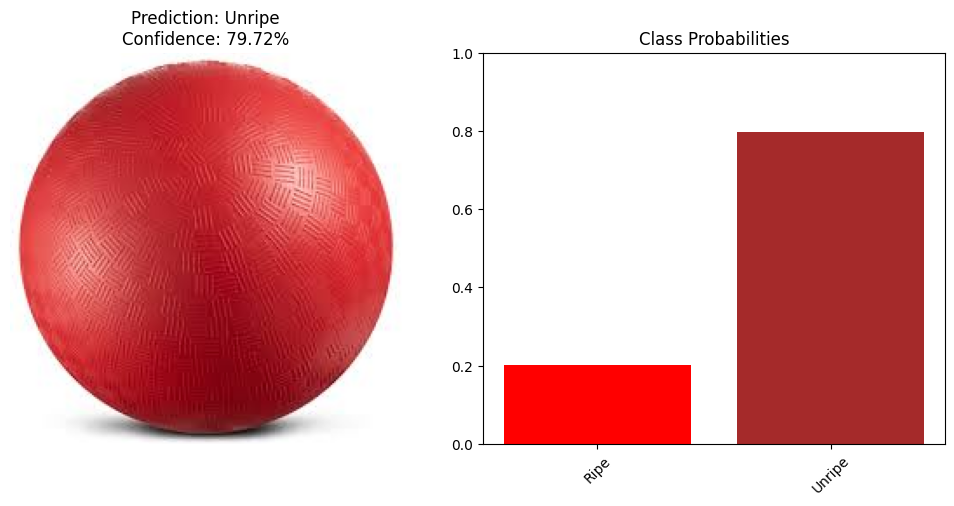


Prediction Results for fake2.jpeg:
Class: Unripe
Confidence: 79.72%

Class Probabilities:
Ripe: 20.28%
Unripe: 79.72%

Final Prediction: Unripe (79.72%)


In [ ]:
def predict_single_image(image_path):
    """
    Predict tomato condition from a single image path
    Args:
        image_path: str, path to the image file
    Returns:
        predicted_class: str, predicted class name
        confidence: float, prediction confidence
    """
    try:
        # Load model
        model = tf.keras.models.load_model('best_disease_detection_model.h5')
        
        # Load and preprocess image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not load image from {image_path}")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMAGE_SIZE)
        img = img / 255.0  # Normalize
        img = np.expand_dims(img, axis=0)

        # Define class labels
        class_labels = ['Ripe', 'Unripe']
        
        # Make prediction
        predictions = model.predict(img)
        class_idx = np.argmax(predictions[0])
        confidence = predictions[0][class_idx]
        predicted_class = class_labels[class_idx]

        # Visualize results
        plt.figure(figsize=(10, 5))
        
        # Show input image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.imread(image_path)[...,::-1])
        plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2%}')
        plt.axis('off')
        
        # Show prediction probabilities
        plt.subplot(1, 2, 2)
        colors = ['red', 'brown', 'green', 'yellow']
        plt.bar(class_labels, predictions[0], color=colors)
        plt.title('Class Probabilities')
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()

        # Print results
        print(f"\nPrediction Results for {os.path.basename(image_path)}:")
        print(f"Class: {predicted_class}")
        print(f"Confidence: {confidence:.2%}")
        
        print("\nClass Probabilities:")
        for class_name, prob in zip(class_labels, predictions[0]):
            print(f"{class_name}: {prob:.2%}")

        return predicted_class, confidence

    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None, None

# Example usage:
if __name__ == "__main__":
    # Test single image
    image_path = r"testing\fake2.jpeg"
    if os.path.exists(image_path):
        prediction, confidence = predict_single_image(image_path)
        if prediction:
            print(f"\nFinal Prediction: {prediction} ({confidence:.2%})")

Found 3736 images belonging to 2 classes.
Found 276 images belonging to 2 classes.

Loading model from best_disease_detection_model.h5...


c:\Users\harsh\.pyenv\pyenv-win\versions\3.10.2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 453ms/step - accuracy: 0.9920 - loss: 0.0403

Validation Accuracy: 98.55%
Validation Loss: 0.0611
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 531ms/step


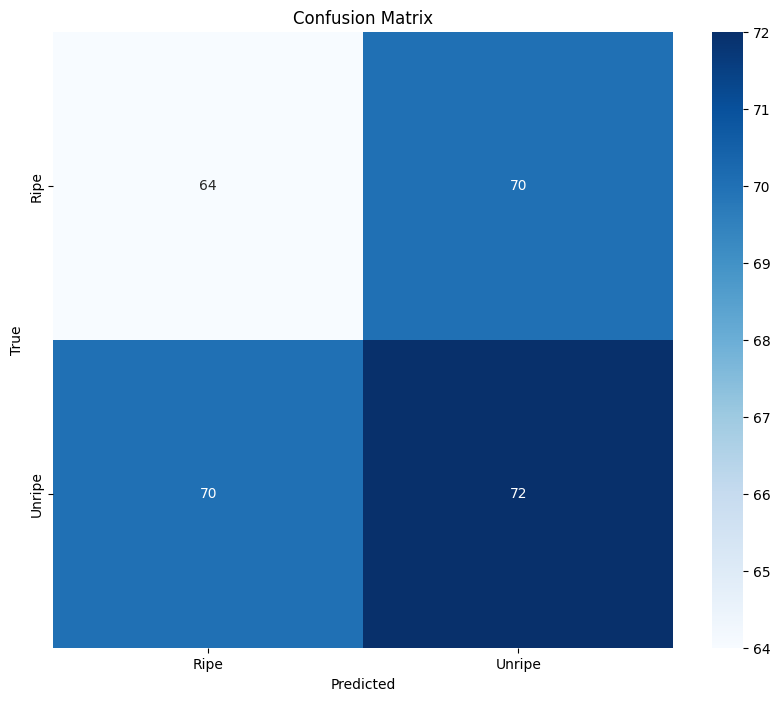


Classification Report:

              precision    recall  f1-score   support

        Ripe       0.48      0.48      0.48       134
      Unripe       0.51      0.51      0.51       142

    accuracy                           0.49       276
   macro avg       0.49      0.49      0.49       276
weighted avg       0.49      0.49      0.49       276



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

def evaluate_model(model, validation_generator):
    # Evaluate accuracy & loss
    loss, accuracy = model.evaluate(validation_generator, verbose=1)
    print(f"\nValidation Accuracy: {accuracy * 100:.2f}%")
    print(f"Validation Loss: {loss:.4f}")

    # Predict classes
    y_pred = model.predict(validation_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # True labels
    y_true = validation_generator.classes

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    class_labels = list(validation_generator.class_indices.keys())

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))
    



def main():
    data_directory = r"C:\Users\harsh\OneDrive\Desktop\Agrolens\tomato_ds"

    # Load validation data
    _, val_gen = load_and_preprocess_data(data_directory)

    # Load saved model
    model_file = 'best_disease_detection_model.h5'
    if os.path.exists(model_file):
        print(f"\nLoading model from {model_file}...")
        model = tf.keras.models.load_model(model_file)

        # Evaluate
        evaluate_model(model, val_gen)
    else:
        print("❌ No trained model found. Please train first.")


if __name__ == "__main__":
    main()


c:\Users\harsh\.pyenv\pyenv-win\versions\3.10.2\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


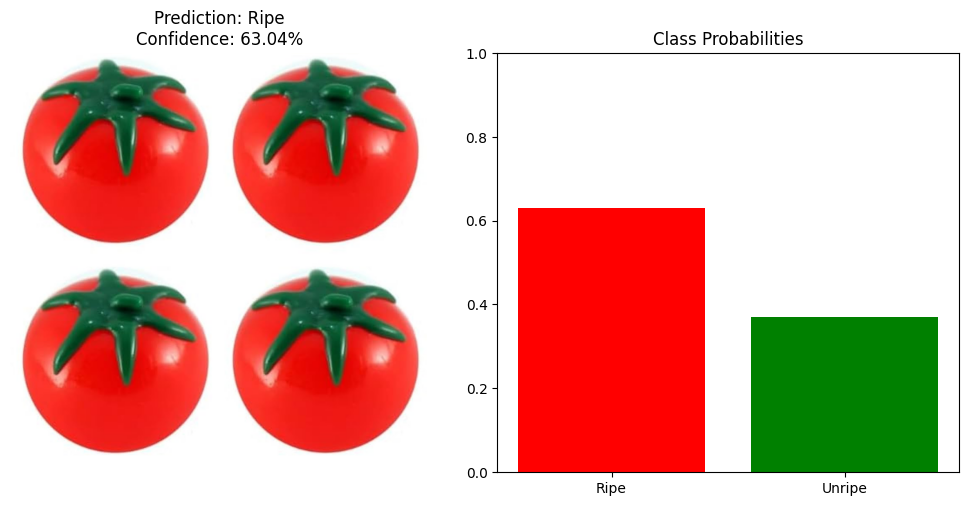


Prediction Results for fake_test.jpg:
Class: Ripe
Confidence: 63.04%

Class Probabilities:
Ripe: 63.04%
Unripe: 36.96%

Final Prediction: Ripe (63.04%)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

IMAGE_SIZE = (224, 224)

def predict_single_image(image_path):
    """
    Predict tomato condition from a single image path using TFLite model
    Args:
        image_path: str, path to the image file
    Returns:
        predicted_class: str, predicted class name
        confidence: float, prediction confidence
    """
    try:
        # Load TFLite model
        interpreter = tf.lite.Interpreter(model_path='tomato_disease_model.tflite')
        interpreter.allocate_tensors()
        
        # Get input and output details
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()
        
        # Load and preprocess image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not load image from {image_path}")
                     
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMAGE_SIZE)
        
        # Check input dtype for proper preprocessing
        if input_details[0]['dtype'] == np.uint8:
            # For quantized models
            input_data = np.expand_dims(img, axis=0).astype(np.uint8)
        else:
            # For float models
            img = img / 255.0  # Normalize
            input_data = np.expand_dims(img, axis=0).astype(np.float32)
        
        # Define class labels for ripe/unripe classification
        class_labels = ['Ripe', 'Unripe']
        
        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)
        
        # Run inference
        interpreter.invoke()
        
        # Get prediction
        predictions = interpreter.get_tensor(output_details[0]['index'])[0]
        
        # Handle output dtype
        if output_details[0]['dtype'] == np.uint8:
            # For quantized models, convert to float probabilities
            predictions = predictions / 255.0
        
        class_idx = np.argmax(predictions)
        confidence = predictions[class_idx]
        predicted_class = class_labels[class_idx]
        
        # Visualize results
        plt.figure(figsize=(10, 5))
                 
        # Show input image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.imread(image_path)[...,::-1])
        plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2%}')
        plt.axis('off')
                 
        # Show prediction probabilities
        plt.subplot(1, 2, 2)
        colors = ['red', 'green']  # Red for ripe, green for unripe
        plt.bar(class_labels, predictions, color=colors)
        plt.title('Class Probabilities')
        plt.xticks(rotation=0)  # No rotation needed for 2 classes
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()
        
        # Print results
        print(f"\nPrediction Results for {os.path.basename(image_path)}:")
        print(f"Class: {predicted_class}")
        print(f"Confidence: {confidence:.2%}")
                 
        print("\nClass Probabilities:")
        for class_name, prob in zip(class_labels, predictions):
            print(f"{class_name}: {prob:.2%}")
        
        return predicted_class, confidence
     
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None, None

# Example usage:
if __name__ == "__main__":
    # Test single image
    image_path = r"testing\fake_test.jpg"
    if os.path.exists(image_path):
        prediction, confidence = predict_single_image(image_path)
        if prediction:
            print(f"\nFinal Prediction: {prediction} ({confidence:.2%})")
    else:
        print(f"Image file not found: {image_path}")